In [1]:
# =============================================
# 1. CONFIGURACIÓN INICIAL
# =============================================

# 1️⃣ Importaciones
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, r2_score
from scipy.stats import spearmanr
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt


# Ruta al DW
db_path = "C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/data/external/chivas_dw.sqlite"

# Conexión
conn = sqlite3.connect(db_path)

# Cargar la vista combinada
df = pd.read_sql_query("SELECT * FROM vw_predicciones_diarias_extendida_v6_ref_actual", conn)
# Cerrar conexión
conn.close()

print(f"Registros cargados: {len(df)}")
df.head()


Registros cargados: 3282


,id_jugador,Fecha,microciclo_ref,tipo_dia_next,Tipo_Dia,Edad,Peso_kg,Estatura_cm,Posicion,Linea,...,pct_pred_menos1_DT:1,DT_pred_menos1_valor:1,pct_pred_mas1_DT:1,DT_pred_mas1_valor:1,pct_pred_mas2_DT:1,DT_pred_mas2_valor:1,CT_total_actual,CE_total_actual,CS_total_actual,CR_total_actual
0,25,2025-05-23,0,NaN,ENTRENO,26,70.0,176.0,Delantero,Extremo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,2025-05-24,0,NaN,ENTRENO,26,70.0,176.0,Delantero,Extremo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25,2025-05-26,1,NaN,ENTRENO,26,70.0,176.0,Delantero,Extremo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25,2025-05-27,1,NaN,ENTRENO,26,70.0,176.0,Delantero,Extremo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25,2025-05-28,1,NaN,ENTRENO,26,70.0,176.0,Delantero,Extremo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# =============================================
# 2.1 FILTRO DE JUGADORES Y MICRO-CICLOS
# =============================================

print(f"Registros cargados pre filtrado: {len(df)}\n")

# Jugadores que deben excluirse
jugadores_excluir = [1, 2, 3, 12, 30]

# Filtrar jugadores no válidos
df = df[~df["id_jugador"].isin(jugadores_excluir)]

# fFiltramos los días nulos o no validos (elimina microciclos fuera de competencia):
df = df[df['tipo_dia_next'].notnull()]


print(f"Registros cargados post filtrado: {len(df)}\n")
# Distribución de la etiqueta
print("\nDistribución de tipo_semana_next:")
print(df['tipo_semana_next'].value_counts(normalize=True) * 100)

Registros cargados pre filtrado: 3282

Registros cargados post filtrado: 2452


Distribución de tipo_semana_next:
tipo_semana_next
RECUPERO    53.361345
CARGA       27.815126
MANTENER    18.823529
Name: proportion, dtype: float64


In [3]:
# =====================================================
# 1️⃣ FILTRO DE DATOS (solo día +3)
# =====================================================
df = df[df['tipo_dia_next'] == 3].copy()

In [4]:
# =====================================================
# 2️⃣ FEATURE ENGINEERING
# =====================================================
# 🔹 Ratios respecto al microciclo de referencia (solo con columnas existentes)
df['CE_ratio_ref'] = df['CE_total_actual'] / df['CE_total_ref']
df['CS_ratio_ref'] = df['CS_total_actual'] / df['CS_total_ref']
df['CT_ratio_ref'] = df['CT_total_actual'] / df['CT_total_ref']

# Limpieza de nulos / infinitos
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [5]:
# =====================================================
# 3️⃣ FEATURE ENGINEERING
# =====================================================
FEATURES = [
    # 🔹 Cargas actuales
    'CT_total_ref', 'CE_total_ref', 'CS_total_ref', 'CR_total_ref',
    'CT_total_actual', 'CE_total_actual', 'CS_total_actual', 'CR_total_actual',

    # 🔹 Estado fisiológico actual
    'riesgo_suavizado_3d_actual',

    # 🔹 Datos antropométricos del jugador
    'Edad', 'Peso_kg', 'Estatura_cm',

    # 🔹 Contexto estructural de la semana siguiente
    'entrenos_total_next', 'descansos_total_next', 'partidos_total_next',
    'descansos_pre_partido_next', 'entrenos_pre_partido_next', 'entrenos_post_partido_next',

    # 🔹 Tipo de semana prevista
    'tipo_semana_next', 

    # 🔹 Tipo de día previsto
    'tipo_dia_next', 

    # 🔹 Totales previstos
    "Distancia_total_total_next", 'CE_total_next', 'CS_total_next',

    # 🔹 Valores Calculados
    'CE_ratio_ref', 'CT_ratio_ref', 'CS_ratio_ref',

    # 🔹 Cargas predichas
    'pct_pred_menos2_CE', 'CE_pred_menos2_valor',
    'pct_pred_menos1_CE', 'CE_pred_menos1_valor',
    'pct_pred_mas1_CE', 'CE_pred_mas1_valor',
    'pct_pred_mas2_CE', 'CE_pred_mas2_valor',
    # opcionalmente incluir CS y DT
    'pct_pred_menos2_CS', 'CS_pred_menos2_valor',
    'pct_pred_menos1_CS', 'CS_pred_menos1_valor',
    'pct_pred_mas1_CS', 'CS_pred_mas1_valor',
    'pct_pred_mas2_CS', 'CS_pred_mas2_valor',
    'pct_pred_menos2_DT', 'DT_pred_menos2_valor',
    'pct_pred_menos1_DT', 'DT_pred_menos1_valor',
    'pct_pred_mas1_DT', 'DT_pred_mas1_valor',
    'pct_pred_mas2_DT', 'DT_pred_mas2_valor'
    
] + [c for c in df.columns if c.startswith('Pos_') or c.startswith('Lin_')]

# 🎯 TARGET
target = 'CE_pct_microciclo'

In [6]:
# =====================================================
# 4️⃣ CODIFICACIÓN Y SPLIT
# =====================================================
X = pd.get_dummies(df[FEATURES], columns=['tipo_semana_next'], drop_first=False)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
# =====================================================
# 5️⃣ ESCALADO Y ENTRENAMIENTO
# =====================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


📊 Métricas de rendimiento (Etapa 4 - días -1, -2, 1 y 2):
R²: 0.295
MAE: 6.585
Correlación Spearman (ρ): 0.533
✅ R² (CV 5 folds): 0.509 ± 0.086


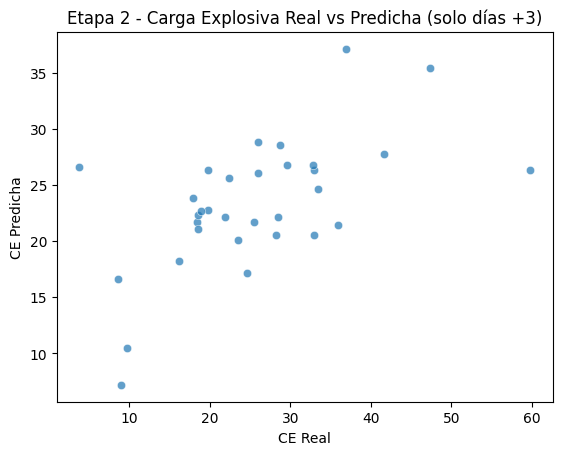

In [8]:
# =====================================================
# 6️⃣ EVALUACIÓN
# =====================================================
y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rho, _ = spearmanr(y_test, y_pred)
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')

print("📊 Métricas de rendimiento (Etapa 4 - días -1, -2, 1 y 2):")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"Correlación Spearman (ρ): {rho:.3f}")
print(f"✅ R² (CV 5 folds): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# =====================================================
# 7️⃣ VISUALIZACIÓN DE COHERENCIA
# =====================================================
df_eval = pd.DataFrame({'Real': y_test, 'Predicho': y_pred})
sns.scatterplot(data=df_eval, x='Real', y='Predicho', alpha=0.7)
plt.title("Etapa 2 - Carga Explosiva Real vs Predicha (solo días +3)")
plt.xlabel("CE Real")
plt.ylabel("CE Predicha")
plt.show()

In [9]:
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import spearmanr

# Agregar las predicciones al dataframe de test
df_eval = X_test.copy()
df_eval['Real'] = y_test.values
df_eval['Predicho'] = y_pred
df_eval['tipo_dia_next'] = df.loc[y_test.index, 'tipo_dia_next'].values  # Aseguramos alineación

# Evaluación por intensidad
resultados_por_intensidad = []
for intensidad in sorted(df_eval['tipo_dia_next'].unique()):
    subset = df_eval[df_eval['tipo_dia_next'] == intensidad]
    if len(subset) < 5:  # evitamos divisiones con muy pocos casos
        continue
    
    r2 = r2_score(subset['Real'], subset['Predicho'])
    mae = mean_absolute_error(subset['Real'], subset['Predicho'])
    rho, _ = spearmanr(subset['Real'], subset['Predicho'])
    
    resultados_por_intensidad.append({
        'Intensidad': intensidad,
        'R²': round(r2, 3),
        'MAE': round(mae, 3),
        'ρ (Spearman)': round(rho, 3),
        'N muestras': len(subset)
    })

df_resultados = pd.DataFrame(resultados_por_intensidad)
print("📊 Resultados por Intensidad:")
display(df_resultados)

📊 Resultados por Intensidad:


,Intensidad,R²,MAE,ρ (Spearman),N muestras
0,3.0,0.295,6.585,0.533,32


In [10]:
# =====================================================
# 8️⃣ EXPORTAR MODELO Y SCALER
# =====================================================
output_dir = r"C:\Users\Nico\Desktop\DATA SCIENCE\PP- VOLUNTAREADO\chivas-ml\src\chivas_ml\ml\registry\Prueba_ML2.0\Modelo_CE_Diario\Modelo_CE_Etapa_4"
os.makedirs(output_dir, exist_ok=True)

joblib.dump(model, os.path.join(output_dir, "model_CE_diario_etapa4.pkl"))
joblib.dump(scaler, os.path.join(output_dir, "scaler_CE_diario_etapa4.pkl"))

print(f"💾 Modelo y scaler guardados en: {output_dir}")

💾 Modelo y scaler guardados en: C:\Users\Nico\Desktop\DATA SCIENCE\PP- VOLUNTAREADO\chivas-ml\src\chivas_ml\ml\registry\Prueba_ML2.0\Modelo_CE_Diario\Modelo_CE_Etapa_4
